In [6]:
import pandas as pd
import seaborn as sns
from FRA import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [17]:
def dist(k, i):
    return np.abs(np.subtract(k, i)).sum()

def region2vec(x):
    columnas = ['a'+str(i)+str(j) for i in range(1,9) for j in range(1,9)]
    vector = []
    for c in columnas:
        vector.append(x[c])
    return vector

focals, strategies = create_regions_and_strategies(8)
complements = [[1 - x for x in sublist] for sublist in focals]
columnas = ['Is_there', 'Dyad', 'Player', 'Round', 'Score', 'DLIndex']
columnas1 = columnas + ['a'+str(i)+str(j) for i in range(1,9) for j in range(1,9)]

data = pd.read_csv('../Data/humans_only_absent.csv')
data = data[columnas1]
data['Region'] = data.apply(region2vec, axis=1)
data['Player'] = data['Player'].apply(lambda x: x[-3:])
data['Absent1'] = data.groupby(['Dyad', 'Player'])['Is_there'].transform('shift',-1)
data['RegionGo'] = data.groupby(['Dyad', 'Player'])['Region'].transform('shift',-1)
data = data[['Absent1'] + columnas + ['Region', 'RegionGo']]
data.head(2)

,Absent1,Is_there,Dyad,Player,Round,Score,DLIndex,Region,RegionGo
0,Unicorn_Absent,Unicorn_Absent,140-615,PL1,1,23.0,0.609375,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Unicorn_Absent,Unicorn_Absent,140-615,PL1,9,27.0,0.828125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
data.sort_values(by=['Dyad', 'Round', 'Player'], inplace=True)
data['Region2'] = data.groupby(['Dyad', 'Round'])['Region'].transform('shift',1)
data['Region1'] = data.groupby(['Dyad', 'Round'])['Region'].transform('shift',-1)
data['RegionOtro'] = data.apply(lambda x: x['Region1'] if x['Player']=='PL1' else x['Region2'], axis=1)
data['Overlap'] = data.apply(lambda x: np.multiply(x['Region'], x['RegionOtro']), axis=1)
del data['Region1']
del data['Region2']
del data['RegionOtro']
data.head()

,Absent1,Is_there,Dyad,Player,Round,Score,DLIndex,Region,RegionGo,Overlap
0,Unicorn_Absent,Unicorn_Absent,140-615,PL1,1,23.0,0.609375,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,Unicorn_Absent,Unicorn_Absent,140-615,PL2,1,23.0,0.609375,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Unicorn_Absent,Unicorn_Absent,140-615,PL1,9,27.0,0.828125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,Unicorn_Absent,Unicorn_Absent,140-615,PL2,9,27.0,0.828125,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Unicorn_Absent,Unicorn_Absent,140-615,PL1,10,32.0,0.421875,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
data['Dists'] = data['Region'].apply(lambda x: [dist(x, f) for f in focals])
data['Dists1'] = data['RegionGo'].apply(lambda x: [dist(x, f) for f in focals])
data['DistsO'] = data['Overlap'].apply(lambda x: [dist(x, f) for f in focals])
data['DistsC'] = data['Overlap'].apply(lambda x: [dist(x, f) for f in complements])
data['Dif'] = data.apply(lambda x: np.subtract(x['Dists'], x['Dists1']).tolist(), axis=1)
data['Size'] = data['Region'].apply(lambda x: np.sum(x))
data['SizeO'] = data['Overlap'].apply(lambda x: np.sum(x))
data['S_score'] = data['Score'].apply(lambda x: sigmoid(x, 10, 30))
data['indice'] = data.index
data.head(2)

,Absent1,Is_there,Dyad,Player,Round,Score,DLIndex,Region,RegionGo,Overlap,Dists,Dists1,DistsO,DistsC,Dif,Size,SizeO,S_score,indice
0,Unicorn_Absent,Unicorn_Absent,140-615,PL1,1,23.0,0.609375,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 44, 12, 52, 36, 28, 28, 36]","[49, 15, 19, 45, 33, 31, 37, 27]","[55, 9, 29, 35, 27, 37, 27, 37]","[9, 55, 35, 29, 37, 27, 37, 27]","[-29, 29, -7, 7, 3, -3, -9, 9]",44,9,3.975450e-31,0
12,Unicorn_Absent,Unicorn_Absent,140-615,PL2,1,23.0,0.609375,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[51, 13, 33, 31, 23, 41, 23, 41]","[16, 48, 48, 16, 34, 30, 24, 40]","[55, 9, 29, 35, 27, 37, 27, 37]","[9, 55, 35, 29, 37, 27, 37, 27]","[35, -35, -15, 15, -11, 11, -1, 1]",13,9,3.975450e-31,12


In [25]:
data['Dists1M'] = data['RegionGo'].apply(lambda x: min([dist(x, f) for f in focals]))

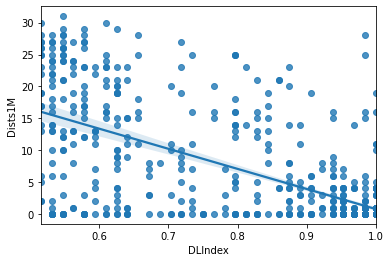

In [28]:
sns.regplot(x='DLIndex', y='Dists1M', data=data[data['DLIndex'] > 0.5])

In [20]:
dict_region = dict(zip(data['indice'], data['Region']))
dict_regionGo = dict(zip(data['indice'], data['RegionGo']))
dict_overlap = dict(zip(data['indice'], data['Overlap']))

sims = []
sims1 = []
simso = []
simsc = []
s_simsc = []
difs = []
dlindex = []
scores = []
size = []
sizeo = []
s_scores = []
reg_focal = []
indice = []

regiones = [0, 1, 2, 3, 4, 5, 6, 7]
for i in regiones:
    sims += data['Dists'].apply(lambda x: x[i]).to_list()
    sims1 += data['Dists1'].apply(lambda x: x[i]).to_list()
    simso += data['DistsO'].apply(lambda x: x[i]).to_list()
    simsc += data['DistsC'].apply(lambda x: x[i]).to_list()
    s_simsc += data['DistsC'].apply(lambda x: 8 - 8*sigmoid(x[i], 1, 4)).to_list()
    difs += data['Dif'].apply(lambda x: x[i]).to_list()
    dlindex += data['DLIndex'].to_list()
    scores += data['Score'].to_list()
    s_scores += data['S_score'].to_list()
    size += data['Size'].to_list()
    sizeo += data['SizeO'].to_list()
    reg_focal += [nameRegion(i+1)]*data.shape[0]
    indice += data['indice'].to_list()

df = pd.DataFrame({
    'Dists1': sims1, 
    'Dists':sims, 
    'DistsO':simso, 
    'DistsC':simsc, 
    'S_DistsC':s_simsc, 
    'Score':scores, 
    'S_score':s_scores, 
    'Size':size, 
    'Sizeo':sizeo,
    'Difs':difs,
    'DLindex':dlindex,
    'Focal': reg_focal,
    'indice':indice
})
df.head()

,Dists1,Dists,DistsO,DistsC,S_DistsC,Score,S_score,Size,Sizeo,Difs,DLindex,Focal,indice
0,49.0,20,55,9,0.053543,23.0,3.975450e-31,44,9,-29.0,0.609375,ALL,0
1,16.0,51,55,9,0.053543,23.0,3.975450e-31,13,9,35.0,0.609375,ALL,12
2,64.0,49,59,5,2.151531,27.0,9.357623e-14,15,5,-15.0,0.828125,ALL,1
3,37.0,16,59,5,2.151531,27.0,9.357623e-14,48,5,-21.0,0.828125,ALL,13
4,64.0,64,64,0,7.856110,32.0,1.000000e+00,0,0,0.0,0.421875,ALL,2


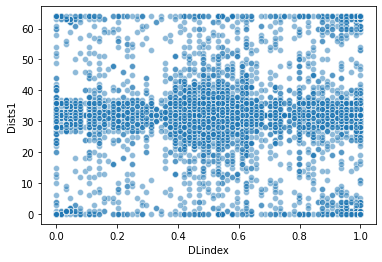

In [22]:
sns.scatterplot(x='DLindex', y='Dists1', data=df, alpha=0.5)